## pix2pix(U-Net + GAN) experiments

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tnrange, tqdm_notebook
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.WARN)

### Model definitions

In [2]:
from utils import load_dataset, save_p2p_models
from utils import plot_p2p_models, plot_p2p_losses
from utils import three_image_generators
from models import g_unet, discriminator, pix2pix
from train import train

Using TensorFlow backend.


### Dataset loading + preprocessing

In [3]:
W = 256
H = 256
dataset_path = '../data/sand'
trend_num = 5
side1_train, side2_train, panorama_train, side1_val, side2_val, panorama_val, N_train, N_val = load_dataset(
    dataset_path, trend_num=trend_num, mode=3, W=W, H=H)

Validation dataset: 100%|██████████| 316/316 [00:02<00:00, 150.74it/s]


In [4]:
batch_size = 50
train_gen, val_gen = three_image_generators(
    side1_train, side2_train, panorama_train, side1_val, side2_val, panorama_val, batch_size=batch_size)

### Training

In [5]:
models_path = 'trained_models/sand'
trend_num = 5
nn_name = 'nf32_cb_eta0'

In [6]:
# создание моделей
nf = 32
f_gen = g_unet(nf)
d = discriminator(nf)
p2p = pix2pix(f_gen, d, eta=0)
#plot_p2p_models(models_path, trend_num, nn_name, f_gen, d, p2p)
#tbCallback = create_tb_callback(models_path, trend_num, nn_name)

In [7]:
# обучение
losses = train(f_gen, d, p2p, train_gen, val_gen, epochs=150,
               train_samples=N_train, val_samples=N_val, batch_size=batch_size)
save_p2p_models(models_path, trend_num, nn_name, f_gen, d, losses)

Epoch 1/1
120/120 [==============================] - 140s - loss: 0.4012   
Epoch 1/1
120/120 [==============================] - 144s - loss: 0.2856   

Models saved successfully


### Trained NN

Dir already exist


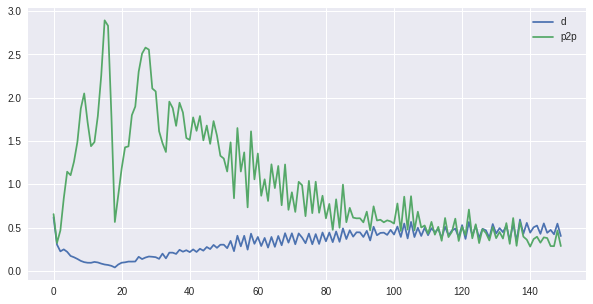

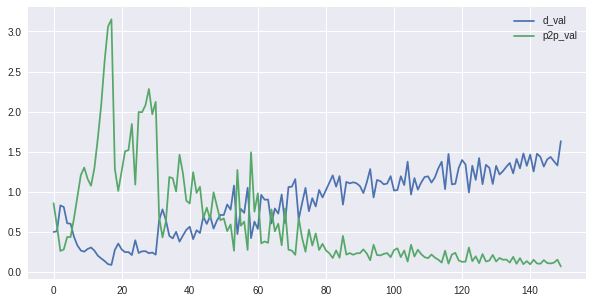

In [8]:
plot_p2p_losses(models_path, trend_num, nn_name, losses)